<a href="https://www.kaggle.com/code/nicksv03/age-gender-detection?scriptVersionId=134744818" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Importing Data

Converting our dataset into TFRecord files. 

In [2]:
maindir = "/kaggle/input/utkface-new/UTKFace"
files = os.listdir(maindir)
size = len(files)
print('total files:', size)

total files: 23708


In [3]:
tf.random.set_seed(51)
np.random.seed(51)

In [4]:
np.random.shuffle(files)

In [5]:
files[0]

'41_0_2_20170116192329504.jpg.chip.jpg'

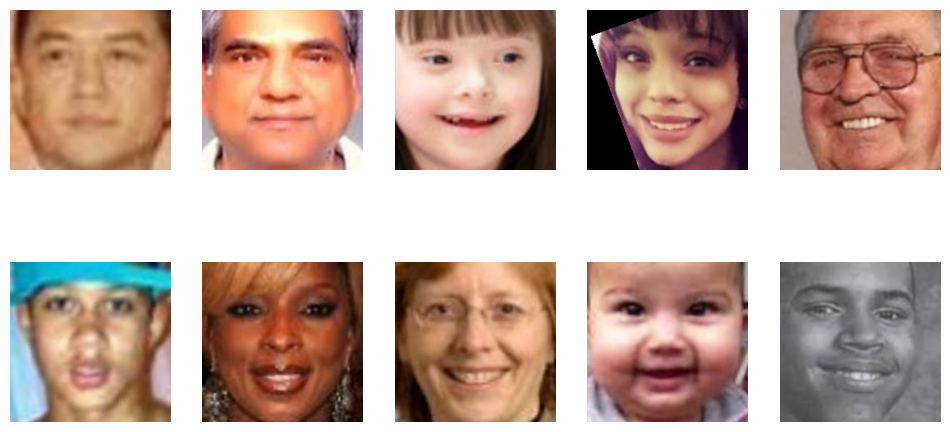

In [6]:
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(os.path.join(maindir,files[image_idx])))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

In [7]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

In [8]:
def create_example(folder_path, filepath):
    full_path = os.path.join(folder_path, filepath)
    image = tf.io.serialize_tensor(np.array(Image.open(full_path)))
    split = filepath.split('_')
    age = int(split[0])
    gender = int(split[1])
    
    example = Example(
        features = Features(
            feature = {
                'image' : Feature(bytes_list=BytesList(value=[image.numpy()])),
                'age' : Feature(int64_list=Int64List(value=[age])),
            }
        )
    )
    return example

In [9]:
def create_tf_record(set_, filename):
    with tf.io.TFRecordWriter('%s.tfrecord' %filename) as f:
        for filepath in set_:
            if filepath != 'utkcropped':
                example = create_example(maindir, filepath)
                f.write(example.SerializeToString())

In [10]:
train_range = [i for i in range (0,16596)]
valid_range = [i for i in range (16597, 18968)]
test_range = [i for i in range (18969, len(files)+1)]

In [11]:
create_tf_record(files[:16597], 'train_set')

In [12]:
create_tf_record(files[16597:18968], 'valid_set')

In [13]:
create_tf_record(files[18968:], 'test_set')

In [14]:
@tf.function
def preprocess(tfrecord):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'age': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)